In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('shorttest.csv', engine='c')

<AxesSubplot:>

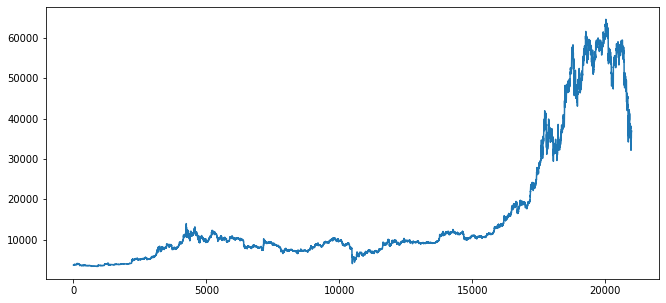

In [3]:
df.Close.plot(figsize=(11,5))

In [4]:
past = 24 * 7
future = 24 * 4

gap = 3
cv_splits = 4
train_size = 24 * 90
test_size = 24 * 14

learning_rate = 1e-3
batch_size = 32
epochs = 10

In [5]:
def split_Xy(data):
    inputs, targets = [], []
    start = gap * -1
    while (start + past + future) < data.shape[0]:
        start += gap
        inputs.append(data[start:(start + past)])
        targets.append(data[(start + past): (start + past + future)])
        
    return np.vstack(inputs), np.vstack(targets)


class DataNormalizer:
    def __init__(self):
        self.mean = 0
        self.std = 1
        
    def fit(self, X):
        self.mean = X.mean(axis=1)
        self.std = X.std(axis=1)
        
    def transform(self, X):
        return (X - np.expand_dims(self.mean, axis=1)) / np.expand_dims(self.std, axis=1)
    
    def inverse_transform(self, X):
        return X * np.expand_dims(self.std, axis=1) + np.expand_dims(self.mean, axis=1)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


def split_and_transform(data):
    norm = DataNormalizer()
    X, y = split_Xy(data)
    X = norm.fit_transform(X)
    y = norm.transform(y)
    return X, y, norm


def get_model():
    tf.keras.backend.clear_session()

    inputs = keras.layers.Input(shape=(past))
    x = keras.layers.Dense(32)(inputs)
    y = keras.layers.Dense(future)(x)
    
    model = keras.Model(inputs=inputs, outputs=y)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


def plot_sample(X, y_true, y_pred=[]):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(range(len(X)), X)
    ax.plot(range(len(X) + len(y_true)), np.repeat(np.nan, len(X)).tolist() + y_true.tolist())
    if len(y_pred) > 0:
        ax.plot(range(len(X) + len(y_pred)), np.repeat(np.nan, len(X)).tolist() + y_pred.tolist())
    plt.legend(['input', 'y_true', 'y_pred'])
    plt.show()
    

def plot_model(X, y_true, n=5):
    idx = random.sample(list(range(len(X))), 5)
    y_pred = model.predict(X[idx])
    for i in range(n):
        plot_sample(X[idx[i]], y_true[idx[i]], y_pred[i])

========== Model loss: 3.8 ==========


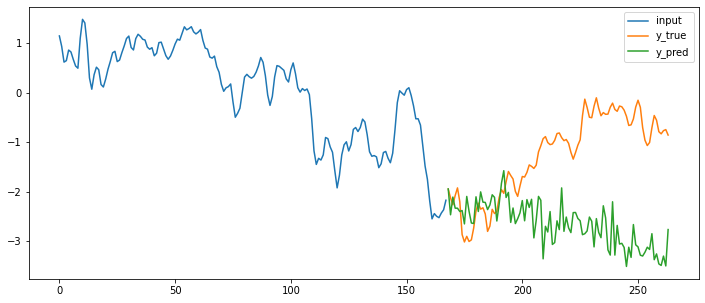

========== Model loss: 5.99 ==========


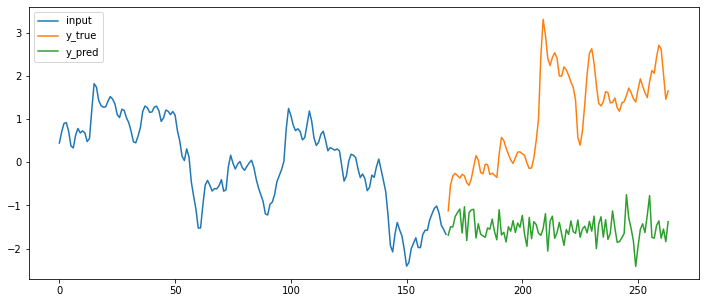

========== Model loss: 1.39 ==========


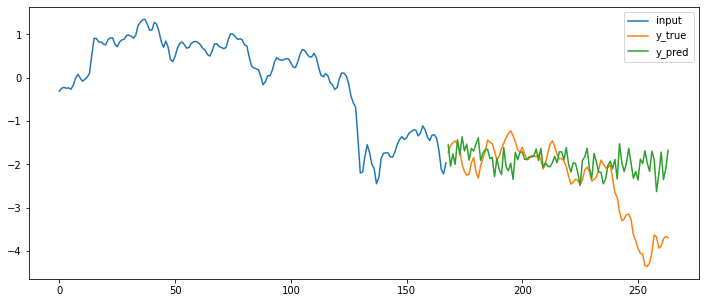

========== Model loss: 2.08 ==========


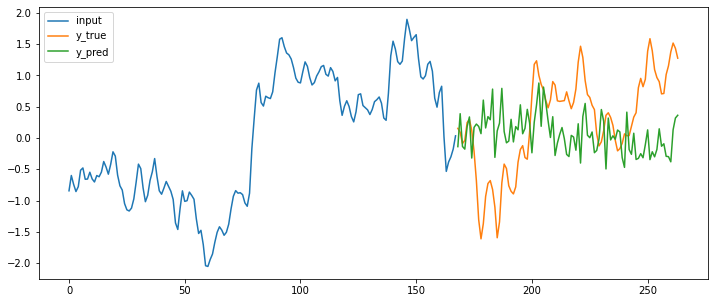

========== Model loss: 2.21 ==========


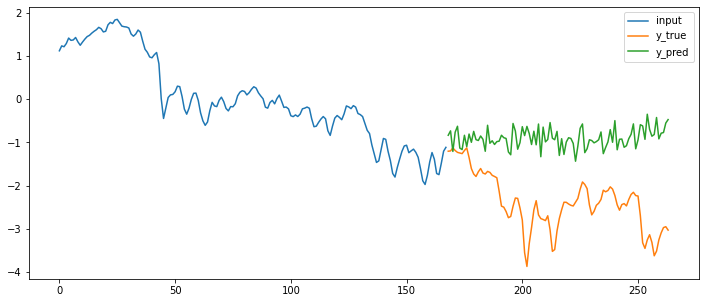

In [6]:
tscv = TimeSeriesSplit(n_splits=cv_splits, max_train_size=train_size, test_size=test_size)

for train_idx, test_idx in tscv.split(df.Close):
    train, test = df.Close.values[train_idx], df.Close.values[test_idx]
    X_train, y_train, _ = split_and_transform(train)
    X_test, y_test, _ = split_and_transform(test)
    
    model = get_model()
    model.fit(
        X_train, y_train,
        batch_size,
        epochs,
        validation_data=(X_test, y_test),
        verbose=False
    )
    loss = model.evaluate(X_test, y_test, verbose=False)
    print(f'{"=" * 10} Model loss: {round(loss, 2)} {"=" * 10}')
    plot_model(X_test, y_test, 1)